In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from math import ceil
from itertools import cycle

#from keras.callbacks import LambdaCallback
#from keras.models import Sequential
#from keras.layers import Dense, Activation
#from keras.layers import LSTM
#from keras.optimizers import RMSprop

%matplotlib inline

In [2]:
#Read in .csv files into pandas dataframes
train       = pd.read_csv('sales_train.csv')
test        = pd.read_csv('test.csv')
submission  = pd.read_csv('sample_submission.csv')
items       = pd.read_csv('items.csv')
item_cats   = pd.read_csv('item_categories.csv')
shops       = pd.read_csv('shops.csv')

In [3]:
#Metadata about the dataframes. Includes size of frame and size of entries
print("----------Top-5- Record----------")
print(train.head(5))
print("-----------Information-----------")
print(train.info())
print("-----------Data Types-----------")
print(train.dtypes)
print("----------Missing value-----------")
print(train.isnull().sum())
print("----------Null value-----------")
print(train.isna().sum())
print("----------Shape of Data----------")
print(train.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num  

In [4]:
#Down casts the data entries from int64 to int32 and float64 to float32
#This reduces the size of the records by almost half. (From 134mb to 61mb)
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [5]:
#Calls the downcasting function
train = downcast_dtypes(train)

In [6]:
#Shows the new metadata of the frame
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


In [7]:
# group data by month and shop_id, return sum of items sold per shop per month
month_group = pd.DataFrame(train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum().reset_index())

# added the item_category into sales_train
merged = pd.merge(train, items[['item_id', 'item_category_id']], on = 'item_id')

# group data by month and category_id, return sum of items sold per category per month
category_group = pd.DataFrame(merged.groupby(['date_block_num', 'item_category_id'])['item_cnt_day'].sum().reset_index())

NameError: name 'cycle' is not defined

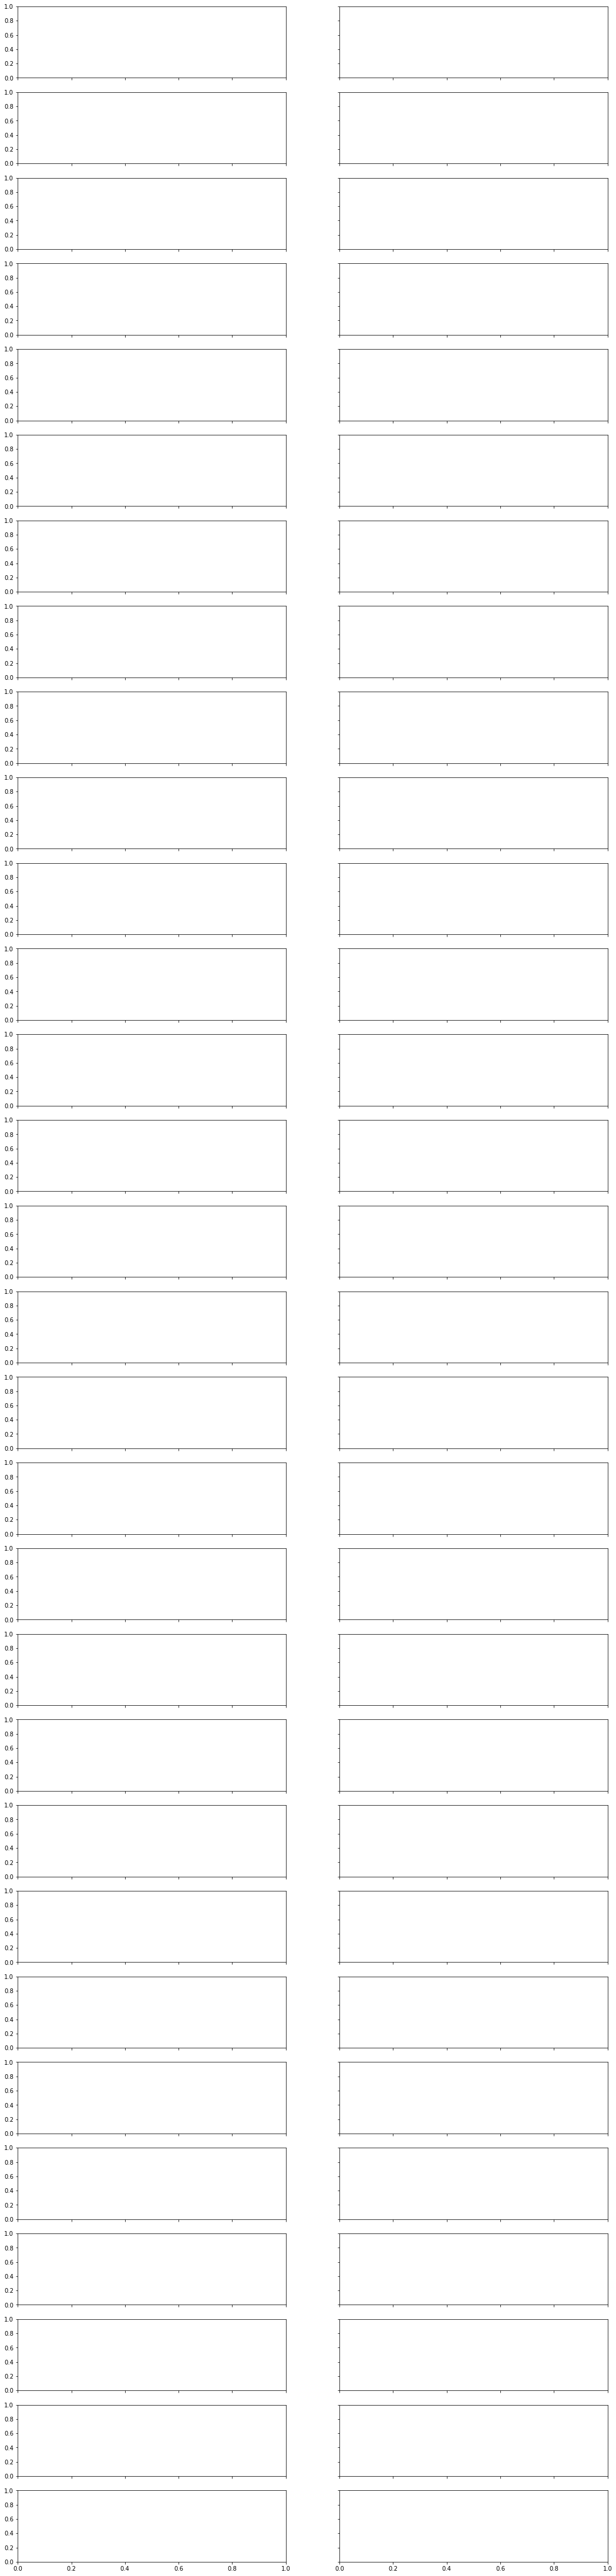

In [23]:
# plotting data for visual reference
fig1, axes = plt.subplots(30, 2, figsize = (18,80), sharex = True, sharey = True)
shop = 0
axis = []

for i in range(int(np.max(month_group['shop_id'])/2+1)):
    axis.append([[[],[]],[[],[]]])
    
for row in range(30):
    for col in range(2):
        for date in range(len(month_group['shop_id'])):
            if month_group['shop_id'][date] == shop:
                axis[row][col][0].append(month_group['date_block_num'][date])
                axis[row][col][1].append(month_group['item_cnt_day'][date])
        shop+=1
        
shop = 0
cycol = cycle('bgrcmk')
for row in range(30):
    for col in range(2):
        axes[row, col].plot(axis[row][col][0], axis[row][col][1], color = next(cycol))
        axes[row, col].set_title('shop ' + str(shop))
        shop += 1

In [7]:
last_date_num = train['date_block_num'][len(train)-1]

# This array has to be changed later for all shops
shop = [[0, 0, 0] for i in range(last_date_num)]
    
month_index = [0]

shop_num = [6, 7, 10]

# to get indices for every block month
for i in range(len(train['date'])-1):
    if train['date_block_num'][i+1] == 1 + train['date_block_num'][i]:
        month_index.append(i+1)

In [8]:
# to sum the num of items per shop for each month
# apply for loop for later for all shops
# this loop is only for 1 shop     
for j in range(len(month_index)-1):
    for k in range(month_index[j],month_index[j+1]):
        for z in range(len(shop_num)):
            if train['shop_id'][k] == shop_num[z]:
                shop[j][z] += train['item_cnt_day'][k]

In [9]:
# represent data into x and y format for plotting
# this only represents 3 shops data
x = [i for i in range(1, last_date_num+1)]
y6 = [j for i in range(33) for j in shop[i] if j == shop[i][0]]
y7 = [j for i in range(33) for j in shop[i] if j == shop[i][1]]
y10 = [j for i in range(33) for j in shop[i] if j == shop[i][2]]

Text(0, 0.5, 'Number of items')

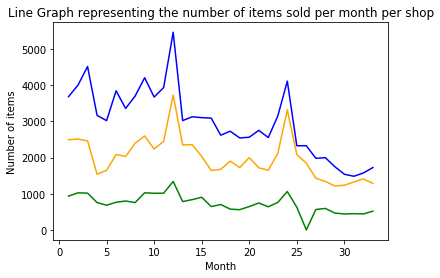

In [10]:
# plot the data
plt.plot(x, y6, color = 'blue', label = 'shop 6')
plt.plot(x, y7, color = 'orange', label = 'shop 7')
plt.plot(x, y10, color = 'green', label = 'shop 10')
plt.title('Line Graph representing the number of items sold per month per shop')
plt.xlabel('Month')
plt.ylabel('Number of items')